# Predikcija čvrstoće betona
Predviđamo **pritisnu čvrstoću betona (MPa)** na osnovu sastava mešavine.
Dataset: 1030 uzoraka, 8 ulaznih obeležja (cement, voda, dodaci, starost...), 1 ciljna promenljiva.

## Istraživačka pitanja
1. **Q1** - Koji sastojci najviše utiču na čvrstoću? → Feature importance
2. **Q2** - Da li je linearna regresija dovoljna? → Poređenje OLS vs RF vs XGBoost
3. **Q3** - Koji sastav i starost daju najveću čvrstoću? → Top 10 predikcija XGBoost-a

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "src")

from preprocessing import load_data, add_features
from visualization import (
    print_data_overview,
    plot_strength_distribution,
    plot_boxplots,
    plot_scatter_vs_strength,
    plot_age_vs_strength,
    plot_correlation_heatmap,
)

## Dataset

In [2]:
df = load_data()
print_data_overview(df)

PREGLED DATASETA

Oblik dataseta: (1030, 9) — 1030 redova i 9 kolona

Informacije o kolonama:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Osnovne statistike:
        Cement  Blast Furnace Slag  Fly Ash    Water  Superplasticizer  \
count  1030.00             1030.00  1030.00  1030.00           1030.00   
mean    281.17               73.90  

Dataset je čist: nema nedostajućih vrednosti ni duplikata. Sve promenljive su numeričke.

## Eksploratorna analiza podataka

### Distribucija ciljne promenljive

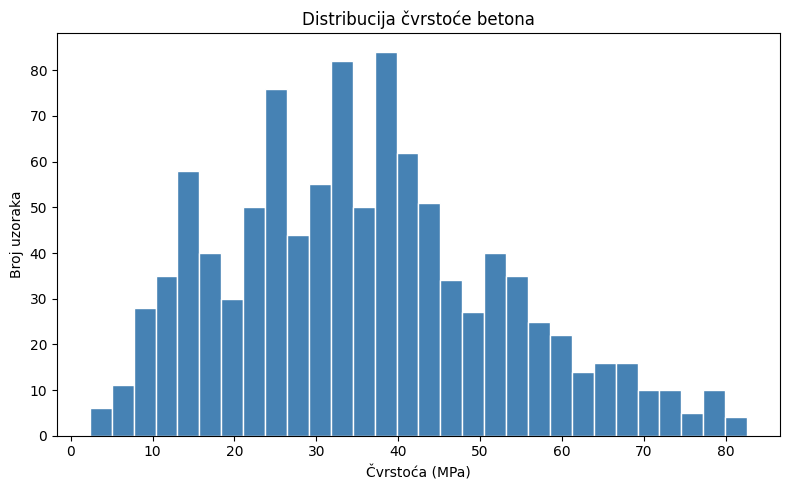

In [3]:
df_feat = add_features(df)
plot_strength_distribution(df_feat)

Čvrstoća betona je približno normalno raspoređena (22–45 MPa), sa blagom desnom asimetrijom.

### Odnos obeležja i čvrstoće

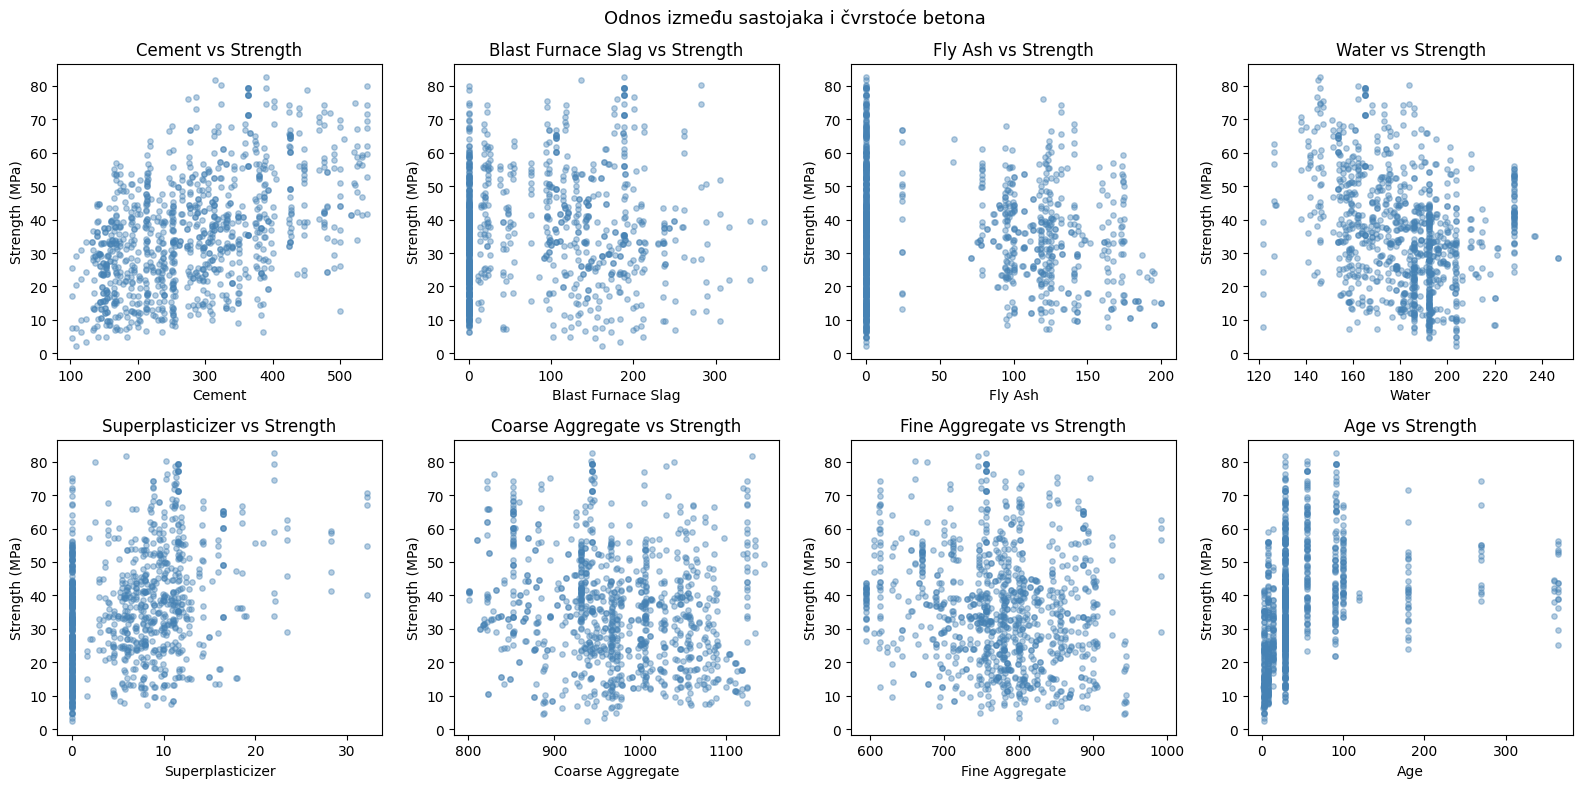

In [4]:
plot_scatter_vs_strength(df_feat)

Veze između obeležja i čvrstoće su pretežno **nelinearne** - što motiviše upotrebu RF i XGBoost modela pored OLS-a.

Uočavaju se i **vertikalne linije nula vrednosti** kod Blast Furnace Slag, Fly Ash i Superplasticizer - ovo nisu greške u podacima, već odraz toga da su ti sastojci **opcioni dodaci**: nisu prisutni u svakoj betonskoj mešavini. Vrednost 0 znači da dati sastojak nije korišćen. Za modele koje koristimo ovo nije problem - OLS tretira nulu kao validnu numeričku vrednost, a RF i XGBoost prirodno uče granicu između "sastojak korišćen / nije korišćen" kroz podele u stablima.

### Uticaj starosti betona na čvrstoću

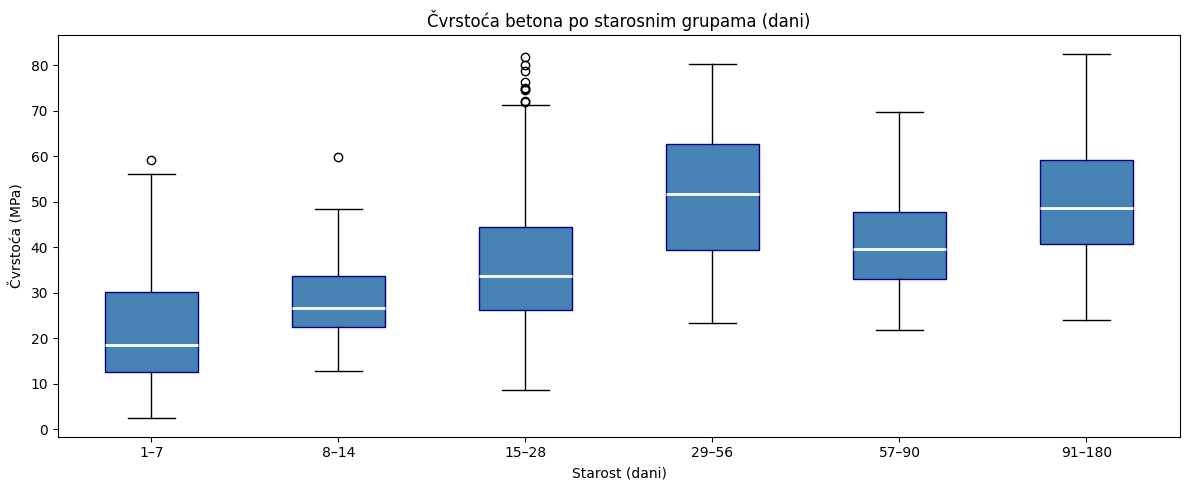

In [5]:
plot_age_vs_strength(df_feat)

Stariji beton je generalno čvršći- Age je jedan od najvažnijih prediktora. Posebno je važno primetiti da veza **nije linearna**: čvrstoća raste ubrzano do ~28 dana (standardni period negovanja betona), a zatim usporava i stabilizuje se. Ovakav nelinearni obrazac direktno ohrabruje primenu modela koji mogu da ga uhvate- Random Forest i XGBoost, za razliku od OLS-a koji pretpostavlja linearnu vezu.

### Korelaciona matrica

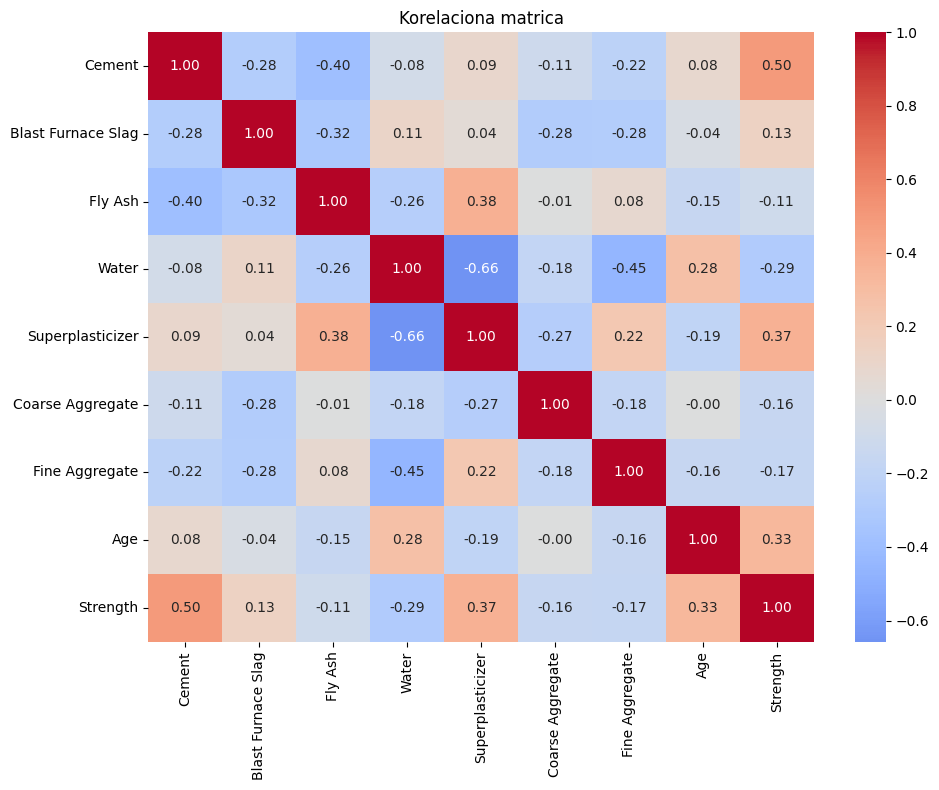

In [6]:
plot_correlation_heatmap(df_feat)

Cement (0.50) i Age (0.33) imaju najveću pozitivnu korelaciju sa čvrstoćom. Water ima negativnu korelaciju (-0.29) - u skladu sa Abrams-ovim zakonom (više vode -> manja čvrstoća).

Uočava se i **kolinearnost između prediktora** - npr. Blast Furnace Slag i Fly Ash su negativno korelisani sa Cement-om, što ima smisla jer se koriste kao delimična zamena za cement u mešavini. Ipak, **nijednu promenljivu ne možemo izbaciti**: sve su fizički sastojci betonske mešavine i svaka direktno utiče na njenu strukturu. Izbacivanje bilo koje od njih ne bi imalo smisla ni sa stanovišta domenskog znanja.

### Box plotovi obeležja (pre obrade)

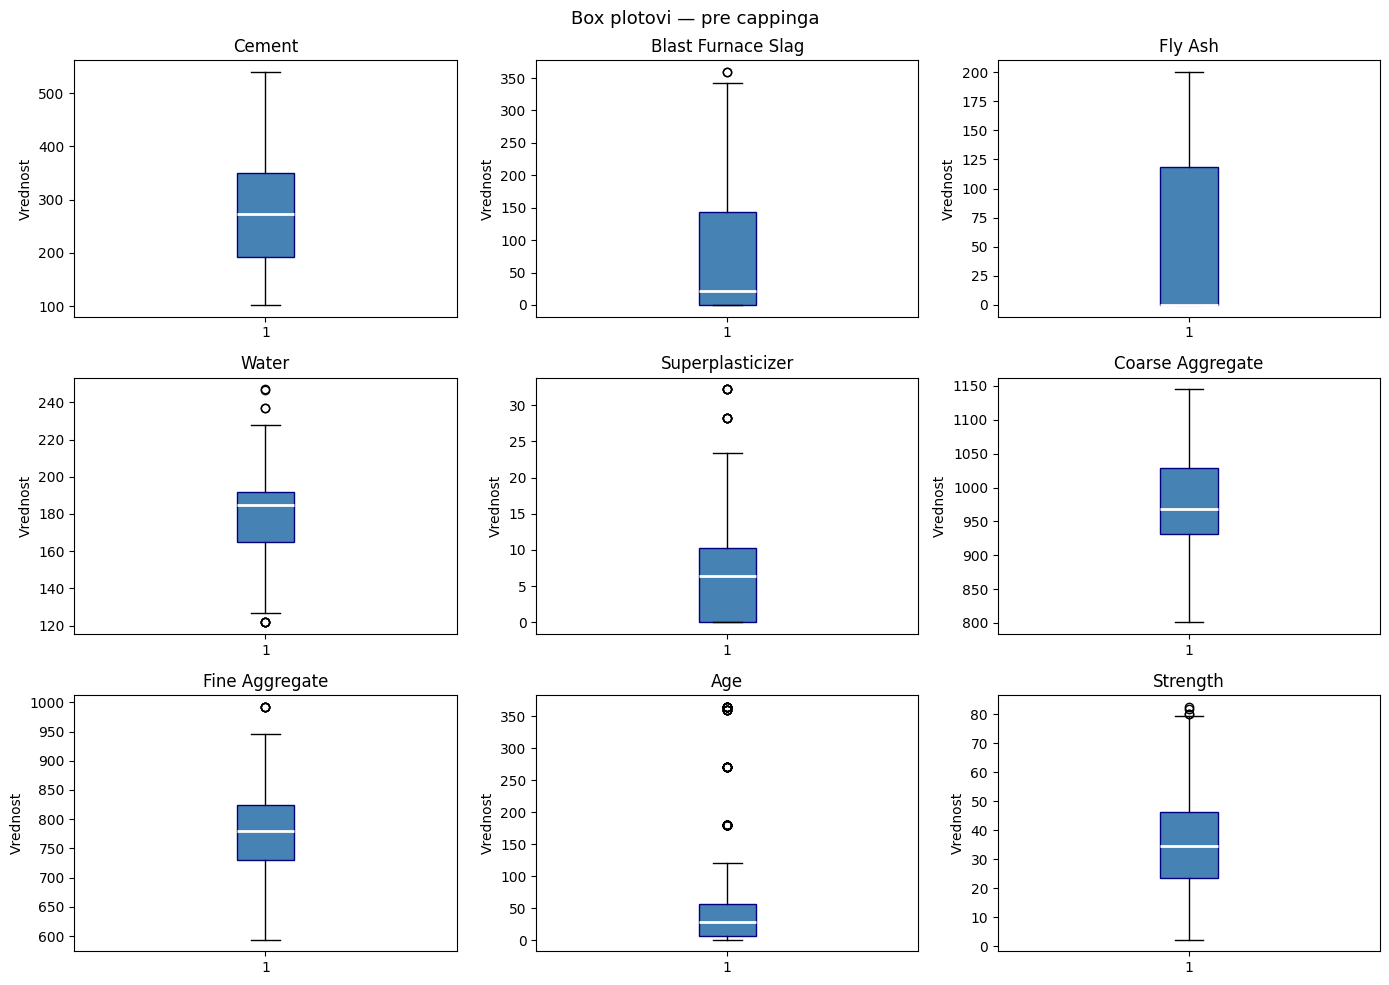

In [7]:
plot_boxplots(df_feat)

Uočavaju se outlieri, posebno kod Superplasticizer i Blast Furnace Slag -> motivisaće capping u narednom koraku preprocessinga radi poboljsanja OLS modela.